In [2]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
import glob
from scipy.stats import pearsonr

from lifelines import KaplanMeierFitter
from lifelines import WeibullAFTFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from datetime import datetime
from scipy.stats import chi2

from multiprocessing import Pool

In [3]:
#tag = "26_nov"
tag = "20_dec_21"
pheno_cols = ["ADP_pred"]

# Read phenotypes scores

In [28]:
export_folder

'/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing'

In [29]:
scores_SNPs = pd.read_hdf("%s/UKB_causal_SNPS_genotypes/scores.hdf" % export_folder).reset_index()
scores_SNPs["index"] = scores_SNPs["index"].str.split("_",expand=True)[0].astype(int)
scores_SNPs = scores_SNPs.rename(columns={"index":"IID"})
scores_SNPs = scores_SNPs.set_index("IID")

In [30]:
SNPs = list(scores_SNPs.columns)

In [31]:
scores_SNPs

,INTERVAL_score,ADP_score,best_pval_score,best_pval_score_homogenous
IID,,,,
3988147,-0.162773,-0.157946,1.707120,0.140237
5152243,-0.172652,0.066470,2.256228,0.256766
2770265,-0.417057,-0.201585,1.126283,0.048714
3790399,-0.629205,-0.969309,0.718756,-0.088707
4681935,-0.399746,0.014031,0.543380,0.083153
...,...,...,...,...
4494916,-0.265494,-0.253767,1.924028,0.183382
4272180,-0.104392,-0.360849,0.959760,0.049855
2654475,-0.014894,-0.322015,1.140520,0.073805


# Read Sysmex Scores

In [32]:
sys_phenos = ["PLT#","MPV","PCT","PDW"]
score_dfs = []
for pheno in sys_phenos:
    dfs = []
    chrom_files = glob.glob("%s/Genetic_score_Sysmex_traits/%s_causal_score_chr*.sscore" % (export_folder,pheno))
    for i, score_file in enumerate(chrom_files):
        df = pd.read_csv(score_file,sep="\t")
        df["score"] = df["SCORE1_AVG"]
        dfs.append(df[["IID","score"]].rename(columns={"score":"score_%d" % i}))
    df = dfs[0]
    for d in dfs[1:]:
        df = pd.merge(df,d,left_on="IID",right_on="IID",how="inner")
    df = df.set_index("IID")
    score_dfs.append(pd.DataFrame(df.sum(axis=1)).rename(columns={0:pheno}))
scores_sys = pd.concat(score_dfs,axis=1)

In [33]:
scores_sys = scores_sys.rename(columns={"PLT#":"PLT"})
scores_sys = scores_sys.add_suffix("_score")
scores_sys

,PLT_score,MPV_score,PCT_score,PDW_score
IID,,,,
3988147,0.011610,-0.027600,0.007958,-0.005995
5152243,0.007862,-0.016196,0.005119,-0.002073
2770265,0.004983,-0.039424,-0.017437,-0.003341
3790399,-0.001070,-0.027039,-0.009639,0.011838
4681935,0.012693,-0.028224,0.001313,-0.005025
...,...,...,...,...
4494916,0.014897,-0.021669,0.001732,0.019635
4272180,-0.001114,-0.017683,-0.004186,0.024122
2654475,0.020629,-0.039821,-0.000400,-0.003238


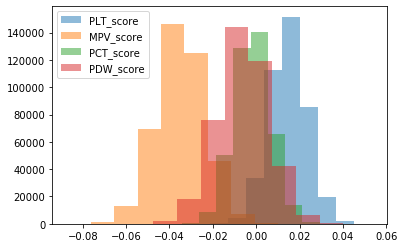

In [34]:
for c in scores_sys.columns:
    plt.hist(scores_sys[c],alpha=.5,label=c)
plt.legend()

In [35]:
scores = pd.merge(scores_SNPs, scores_sys,left_index=True,right_index=True).rename(columns={"IPF":"IPF_score"})

In [36]:
scores.head()

,INTERVAL_score,ADP_score,best_pval_score,best_pval_score_homogenous,PLT_score,MPV_score,PCT_score,PDW_score
IID,,,,,,,,
3988147,-0.162773,-0.157946,1.707120,0.140237,0.011610,-0.027600,0.007958,-0.005995
5152243,-0.172652,0.066470,2.256228,0.256766,0.007862,-0.016196,0.005119,-0.002073
2770265,-0.417057,-0.201585,1.126283,0.048714,0.004983,-0.039424,-0.017437,-0.003341
3790399,-0.629205,-0.969309,0.718756,-0.088707,-0.001070,-0.027039,-0.009639,0.011838
4681935,-0.399746,0.014031,0.543380,0.083153,0.012693,-0.028224,0.001313,-0.005025


In [37]:
# Export

scores.to_hdf("%s/scores_table.hdf" % export_folder,key="scores")

# Read UKBB outcomes

In [4]:
col_index = pd.read_csv("%s/Data_Dictionary_Showcase.tsv" % export_folder,sep="\t")
col_index.head(2)

,Path,Category,FieldID,Field,Participants,Items,Stability,ValueType,Units,ItemType,...,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82
0,UK Biobank Assessment Centre > Procedural metr...,152,3,Verbal interview duration,501635,568440,Complete,Integer,seconds,Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UK Biobank Assessment Centre > Procedural metr...,152,4,Biometrics duration,497955,568328,Complete,Integer,seconds,Data,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
ages = col_index.loc[col_index.Field.str.contains("Age")].set_index("FieldID")["Field"].to_dict()
ages_cols = ["%d-0.0" % a for a in ages]

In [6]:
ages

{845: 'Age completed full time education',
 2139: 'Age first had sexual intercourse',
 2217: 'Age started wearing glasses or contact lenses',
 2714: 'Age when periods started (menarche)',
 2754: 'Age at first live birth',
 2764: 'Age at last live birth',
 2794: 'Age started oral contraceptive pill',
 2804: 'Age when last used oral contraceptive pill',
 2824: 'Age at hysterectomy',
 2867: 'Age started smoking in former smokers',
 2897: 'Age stopped smoking',
 2966: 'Age high blood pressure diagnosed',
 2976: 'Age diabetes diagnosed',
 3436: 'Age started smoking in current smokers',
 3536: 'Age started hormone-replacement therapy (HRT)',
 3546: 'Age last used hormone-replacement therapy (HRT)',
 3581: 'Age at menopause (last menstrual period)',
 3627: 'Age angina diagnosed',
 3680: 'Age when last ate meat',
 3761: 'Age hay fever, rhinitis or eczema diagnosed',
 3786: 'Age asthma diagnosed',
 3872: 'Age of primiparous women at birth of child',
 3882: 'Age at bilateral oophorectomy (both o

In [17]:
ukbb_path = "/home/hv270/rds/rds-who1000-cbrc/data/UKB_13745/flat_data/ukb44092.csv"
SEX_FIELD = "31-0.0" # 0 female, 1 male
ID_FIELD = "eid"
DEATH_FIELD = '40007-0.0' # Age at death
BIRTH_FIELD = "34-0.0"
KINSHIP = '22021-0.0'
SMOKING_FIELD = "20161-0.0"
CHOLESTEROL_FIELD = "30690-0.0" 
DIABETES_FIELD = "2443-0.0"
BMI_FIELD = "21001-0.0"
CRP_FIELD = "30710-0.0"
HDL_FIELD = "30760-0.0"
SYSTOLIC_BP_FIELD = "4080-0.0"
ICD10_sec_code = ['41270-0.%d' % i for i in range(213)]
ICD10_sec_date = ['41280-0.%d' % i for i in range(213)]
genetic_PCs = ["22009-0.%d" % i for i in range(1,11)]
ICD10_prim_dates = col_index.loc[col_index["Field"].str.contains("Date") &\
                                 col_index["Field"].str.contains("first reported")].FieldID.astype(str).tolist()

# filter out missing ICD10_prim_dates
for chunk in pd.read_csv(ukbb_path,sep=",",chunksize=int(1e2),low_memory=False):
    ukbb_ = chunk
    ICD10_prim_dates_filtered = [c for c in ukbb_.columns if c.split("-")[0] in ICD10_prim_dates]
    break

cols = [ID_FIELD, SEX_FIELD, DEATH_FIELD, BIRTH_FIELD,
        SMOKING_FIELD, SYSTOLIC_BP_FIELD, CHOLESTEROL_FIELD, HDL_FIELD, CRP_FIELD,
        BMI_FIELD, DIABETES_FIELD] + genetic_PCs + ICD10_sec_code + \
        ICD10_sec_date + ages_cols + ICD10_prim_dates_filtered

str_cols = {}
for c in ICD10_sec_code:
    str_cols[c] = str

(array([83.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.11 ,  6.456, 12.802, 19.148, 25.494, 31.84 , 38.186, 44.532,
        50.878, 57.224, 63.57 ]),
 <a list of 10 Patch objects>)

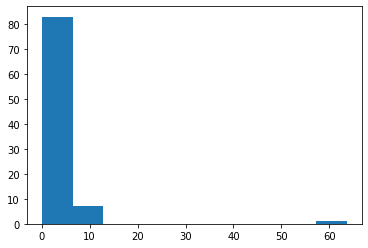

In [21]:
plt.hist(ukbb_[CRP_FIELD])

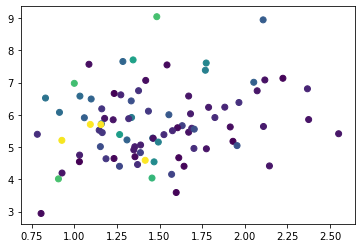

In [22]:
plt.scatter(ukbb_[HDL_FIELD],ukbb_[CHOLESTEROL_FIELD],c=ukbb_[CRP_FIELD],vmax=10)

In [18]:
ukbb_[cols].head()

,eid,31-0.0,40007-0.0,34-0.0,20161-0.0,30690-0.0,21001-0.0,2443-0.0,22009-0.1,22009-0.2,...,132586-0.0,132588-0.0,132590-0.0,132592-0.0,132594-0.0,132596-0.0,132598-0.0,132600-0.0,132602-0.0,132604-0.0
0,6026567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000011,1.0,NaN,1943.0,NaN,7.067,24.8097,0.0,-13.4848,1.06092,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000026,1.0,NaN,1960.0,NaN,4.415,24.2424,0.0,-13.2959,4.07063,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1000032,0.0,NaN,1950.0,NaN,5.915,24.2578,0.0,-15.4969,5.15194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1000044,1.0,NaN,1949.0,NaN,4.404,33.1755,0.0,-11.8955,2.49383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
print("%d columns" % len(cols))

1635 columns


In [23]:
# Read full table
ukbb_ = pd.read_csv(ukbb_path,sep=",",usecols=cols, low_memory=True, 
                    dtype=str_cols,
                    parse_dates=ICD10_sec_date + [BIRTH_FIELD,DEATH_FIELD] + ICD10_prim_dates_filtered);
ukbb_.set_index(ID_FIELD,inplace=True)

In [24]:
rel = pd.read_csv("/home/hv270/rds/rds-wja24-uk-biobank-gen/rel/ukb13745_rel_s488339.dat",sep=" ")
related_people = rel.loc[rel.Kinship < 0.0612].ID2.unique().tolist()

european_individuals = pd.read_csv("/rds/project/wja24/rds-wja24-uk-biobank-gen/13745_specific/blood_trait_gwas_2020_contributing_ids.tsv",header=None)
european_individuals = european_individuals.rename(columns={0:"FID"})
EUR_IDs = european_individuals.FID.tolist()

to_keep = ukbb_.index.isin(EUR_IDs) & ~ukbb_.index.isin(related_people)
print("%d people kept over %d" %(to_keep.sum(),ukbb_.shape[0]))

UKB = ukbb_.loc[to_keep]
UKB = UKB.loc[~UKB[BIRTH_FIELD].isnull()]
UKB = UKB.loc[~UKB[SEX_FIELD].isnull()]

384059 people kept over 502493


In [25]:
UKB["AGE"] = (pd.to_datetime("01-01-2019") - UKB[BIRTH_FIELD]).dt.days // 365
is_dead = ~UKB[DEATH_FIELD].isnull()
UKB.loc[is_dead,"AGE"] = UKB.loc[is_dead,DEATH_FIELD].astype(float)
UKB.to_hdf("%s/UKB.hdf" % export_folder,key="UKB")

/home/hv270/.local/lib/python3.7/site-packages/pandas/core/generic.py:2620: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['40007-0.0', '41270-0.0', '41270-0.1', '41270-0.2', '41270-0.3',
       '41270-0.4', '41270-0.5', '41270-0.6', '41270-0.7', '41270-0.8',
       ...
       '41270-0.203', '41270-0.204', '41270-0.205', '41270-0.206',
       '41270-0.207', '41270-0.208', '41270-0.209', '41270-0.210',
       '41270-0.211', '41270-0.212'],
      dtype='object', length=214)]

  encoding=encoding,


# Stop (no need to go further)

In [23]:
all_ICD10_secondary = []
# On parcourt les colonnes dédiées aux codes ICD10 secondaires
for c in ICD10_sec_code:
    all_ICD10_secondary += [code for code in UKB.loc[~UKB[c].isnull(),c].unique().tolist()]
all_ICD10_secondary = list(set(all_ICD10_secondary))
print(len(all_ICD10_secondary))
print(all_ICD10_secondary[:4])

11107
['E230', 'H618', 'M8052', 'D70']


In [ ]:
all_ICD10_sec_col = UKB[ICD10_sec_code].fillna("").astype(str).apply(lambda x: ' '.join(x), axis = 1) + " "

In [ ]:
all_ICD10_sec_col .head()

eid
1000011    C19 K439 K621 K649 K811 K824 R31 Z080 Z139 Z85...
1000026    M179 M2323 M674 Z302                          ...
1000032    K573 R074                                     ...
1000044    G473 G560 I083 I10 I200 I209 I214 I251 I259 I3...
1000058    D126 E780 F171 J181 K210 K221 K227 K449 K573 K...
dtype: object

In [ ]:
p = Pool(12)
def get_n_cases(c):
    return all_ICD10_sec_col.str.contains(c + " ").sum(), c
n_cases = {}
for n, c in tqdm(p.imap_unordered(get_n_cases,all_ICD10_secondary),total=len(all_ICD10_secondary)):
    n_cases[c] = n
p.close()
p.join()

Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
  0%|          | 0/11107 [00:00<?, ?it/s]Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-5:
Process ForkPoolWorker-6:
Traceback (most recent call last):
Process ForkPoolWorker-8:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Process ForkPoolWorker-12:
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/hv270/platelets/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
Process ForkPoolWorker-7:
AttributeError: Can't get attribute 'get_n_cases' on <module '__main__'>
Traceback (most recent call last):
Trac

In [ ]:
plt.hist([np.log10(n_cases[c]) for c in n_cases]);

In [ ]:
min_n_cases = 150
all_ICD10_100 = [c for c in n_cases if n_cases[c] >= 300] # codes with min_n_cases+ cases

In [ ]:
len(all_ICD10_100)

In [ ]:
ICD10_primary_codes = {} # col -> code
ICD10_primary_desc = {} # col -> desc
col_index["ICD10_code"] = col_index["Field"].str.split(" ",expand=True)[1]
col_index["ICD10_desc"] = col_index["Field"].str.split("(",expand=True)[1].str.split(")",expand=True)[0]
ICD10_primary_codes = col_index.loc[col_index["Field"].str.contains("Date") & 
                            col_index["Field"].str.contains("first reported"),
                            ["FieldID","ICD10_code"]].set_index("FieldID")["ICD10_code"].to_dict()
ICD10_primary_desc = col_index.loc[col_index["Field"].str.contains("Date") & 
                            col_index["Field"].str.contains("first reported"),
                            ["FieldID","ICD10_desc"]].set_index("FieldID")["ICD10_desc"].to_dict()
ICD10_primary_col = {} # code -> col
all_ICD10_primary = []
for c in ICD10_primary_codes:
    ICD10_primary_col[ICD10_primary_codes[c]] = c
    all_ICD10_primary.append(ICD10_primary_codes[c])

In [ ]:
ICD_10_primary_events = []
for code in all_ICD10_primary:
    try:
        s = UKB[str(ICD10_primary_col[code])+"-0.0"].copy()
    except:
        continue
    s = s.loc[~s.isnull()]
    s = pd.DataFrame(s).rename(columns={str(ICD10_primary_col[code])+"-0.0":"Date"}).reset_index()
    s = s.rename(columns={"eid":"ID"})
    s["code"] = code
    ICD_10_primary_events.append(s)
ICD_10_primary_events = pd.concat(ICD_10_primary_events,axis=0)

In [ ]:
ICD_10_primary_events.code.nunique()

In [ ]:
all_ICD10_sec_col

In [ ]:
# Build dict of ICD10_sec_code -> dict of ID -> date
ICD10_sec_event_dates = {}

def get_dates_dict(code):
    dates_dict = {}# ID -> date
    sub = UKB.loc[all_ICD10_sec_col.str.contains(code + " ")]
    for date_col, code_col in zip(ICD10_sec_date,ICD10_sec_code):
        is_code = (sub[code_col] == code)
        dates_dict.update(sub.loc[is_code,date_col].to_dict())
    return code, dates_dict

In [ ]:
p = Pool(12)
for code, d in tqdm(p.imap_unordered(get_dates_dict, all_ICD10_secondary),total=len(all_ICD10_secondary)):
    ICD10_sec_event_dates[code] = d   
p.close()
p.join()

In [ ]:
code_dfs = []
for code in ICD10_sec_event_dates:
    code_df = pd.DataFrame.from_dict(ICD10_sec_event_dates[code],orient="index").rename(columns={0:"Date"}).reset_index()
    code_df["code"] = code
    code_df = code_df.rename(columns={"index":"ID"})
    code_dfs.append(code_df)
all_ICD10_sec_events = pd.concat(code_dfs,axis=0)

In [ ]:
all_ICD10_sec_events.sample(5)

In [ ]:
all_ICD10_events = pd.concat([all_ICD10_sec_events,ICD_10_primary_events],axis=0)

In [ ]:
all_ICD10_events.sample(5)

In [ ]:
all_ICD10_events_shortcodes = all_ICD10_events.copy()
all_ICD10_events_shortcodes["code"] = all_ICD10_events_shortcodes["code"].str.split(".",expand=True)[0]
all_ICD10_events_shortcodes = all_ICD10_events_shortcodes.loc[~all_ICD10_events_shortcodes.code.isin(all_ICD10_events.code.unique().tolist())]
print(all_ICD10_events.code.nunique())
print(all_ICD10_events_shortcodes.code.nunique())
all_ICD10_events = pd.concat([all_ICD10_events,all_ICD10_events_shortcodes],axis=0)
print(all_ICD10_events.code.nunique())

In [ ]:
all_ICD10_events.to_csv("%s/ICD10_events.csv" % export_folder)

In [47]:
pd.set_option('display.max_colwidth', 100)

In [50]:
def show_code(c,strict=False):
    if not strict:
        cond = cox_info.index.astype(str).str.contains(c) & (cox_info.n_cases >= 100)
    else:
        cond = (cox_info.index.astype(str) == c) & (cox_info.n_cases >= 100)
    if cond.sum() == 0 and len(c) == 5:
        if not strict:
            cond = cox_info.index.astype(str).str.contains(c[:-1]) & (cox_info.n_cases >= 100)
        else:
            cond = (cox_info.index.astype(str) == c[:-1]) & (cox_info.n_cases >= 100)
    return cox_info.loc[cond][["desc","HR_ADP","n_cases","MLOG10P","p_val_ADP"]].sort_values("MLOG10P",ascending=False)

## Fibroblastic disorders

In [51]:
show_code("M72")

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
M720,M72.0 Palmar fascial fibromatosis [Dupuytren],0.957202,2800.0,1.501630,0.031504
M7204,M72.04 Palmar fascial fibromatosis [Dupuytren]-Hand,0.962344,1510.0,0.792669,0.161187
M72,fibroblastic disorders,0.994422,18181.0,0.324419,0.473784
M722,M72.2 Plantar fascial fibromatosis,1.031063,252.0,0.195140,0.638057
M7227,M72.27 Plantar fascial fibromatosis-Ankle/Foot,1.020131,122.0,0.082544,0.826905


## Phlebitis

In [52]:
show_code("I80")

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I80,phlebitis and thrombophlebitis,1.030159,12688.0,2.928288,0.001180
I808,I80.8 Phlebitis and thrombophlebitis of other sites,1.182832,172.0,1.682521,0.020772
I802,I80.2 Phlebitis and thrombophlebitis of other deep vessels of lower extremities,1.019204,3069.0,0.507320,0.310942
I801,I80.1 Phlebitis and thrombophlebitis of femoral vein,1.038896,384.0,0.333253,0.464245
I803,"I80.3 Phlebitis and thrombophlebitis of lower extremities, unspecified",1.032254,285.0,0.224515,0.596328
I800,I80.0 Phlebitis and thrombophlebitis of superficial vessels of lower extremities,0.980457,285.0,0.123954,0.751702
I809,I80.9 Phlebitis and thrombophlebitis of unspecified site,0.997359,197.0,0.012087,0.972552


## MI

In [53]:
show_code("I21")

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I214,I21.4 Acute subendocardial myocardial infarction,1.030705,1645.0,0.622544,0.238482
I210,I21.0 Acute transmural myocardial infarction of anterior wall,1.023796,1732.0,0.453263,0.352157
I219,"I21.9 Acute myocardial infarction, unspecified",0.984164,3608.0,0.434150,0.368001
I212,I21.2 Acute transmural myocardial infarction of other sites,0.943374,266.0,0.405101,0.393459
I21,acute myocardial infarction,0.996866,14089.0,0.140573,0.723481
I213,I21.3 Acute transmural myocardial infarction of unspecified site,0.981923,128.0,0.071997,0.847232
I211,I21.1 Acute transmural myocardial infarction of inferior wall,1.002667,2111.0,0.042554,0.906662


## Valve

In [54]:
show_code("I35")

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I358,I35.8 Other aortic valve disorders,0.780694,186.0,2.348429,0.004483
I350,I35.0 Aortic (valve) stenosis,0.955083,2098.0,1.313783,0.048553
I35,nonrheumatic aortic valve disorders,0.968356,3565.0,1.153026,0.070303
I351,I35.1 Aortic (valve) insufficiency,0.952075,857.0,0.745074,0.179856
I359,"I35.9 Aortic valve disorder, unspecified",0.951993,176.0,0.266084,0.541896
I352,I35.2 Aortic (valve) stenosis with insufficiency,1.005994,396.0,0.041543,0.908777


## CVD

In [55]:
CVD = ["I2510","I4891","I639","I6523","16529","I672","I679","I739","I50"]
pd.concat([show_code(c,strict=True) for c in CVD],axis=0).sort_values("MLOG10P",ascending=False)

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I50,heart failure,1.019900,7522.0,0.994742,0.101218
I251,I25.1 Atherosclerotic heart disease,0.988265,19694.0,0.935882,0.115909
I672,I67.2 Cerebral atherosclerosis,0.912913,305.0,0.863228,0.137016
I679,"I67.9 Cerebrovascular disease, unspecified",1.032585,1215.0,0.553752,0.279414
I639,"I63.9 Cerebral infarction, unspecified",0.983626,2849.0,0.391528,0.405949
I739,"I73.9 Peripheral vascular disease, unspecified",0.989412,2950.0,0.232839,0.585008


## Circulatory System Diseases

In [56]:
CSD = ["I209","I2109","I213","I2510","I252","I2584","I259"]
pd.concat([show_code(c,strict=True) for c in CSD],axis=0).sort_values("MLOG10P",ascending=False)

,desc,HR_ADP,n_cases,MLOG10P,p_val_ADP
I251,I25.1 Atherosclerotic heart disease,0.988265,19694.0,0.935882,0.115909
I209,"I20.9 Angina pectoris, unspecified",0.990139,16520.0,0.645331,0.226292
I210,I21.0 Acute transmural myocardial infarction of anterior wall,1.023796,1732.0,0.453263,0.352157
I259,"I25.9 Chronic ischaemic heart disease, unspecified",1.004628,13100.0,0.212580,0.612943
I258,I25.8 Other forms of chronic ischaemic heart disease,1.006070,6661.0,0.196427,0.636169
I252,I25.2 Old myocardial infarction,0.996149,8981.0,0.137484,0.728645
I213,I21.3 Acute transmural myocardial infarction of unspecified site,0.981923,128.0,0.071997,0.847232


## Overall

In [58]:
min_n_cases = 100
print((cox_info.n_cases >= min_n_cases).sum())
cox_info.loc[(cox_info.n_cases >= min_n_cases)].sort_values("MLOG10P",ascending=False).head(50)[["desc","HR_ADP","n_cases","MLOG10P"]]

2915


,desc,HR_ADP,n_cases,MLOG10P
O809,"O80.9 Single spontaneous delivery, unspecified (unisex)",1.208713,413.0,4.232883
K659,"K65.9 Peritonitis, unspecified",0.772832,282.0,3.694291
M549,"M54.9 Dorsalgia, unspecified",0.930467,2874.0,3.413167
K20,oesophagitis,1.035055,11273.0,3.378355
K768,K76.8 Other specified diseases of liver,0.892724,1078.0,3.123342
N131,"N13.1 Hydronephrosis with ureteral stricture, not elsewhere classified",0.779098,261.0,3.102395
Q82,other congenital malformations of skin,0.904576,1266.0,2.945060
I80,phlebitis and thrombophlebitis,1.030159,12688.0,2.928288
B962,B96.2 Escherichia coli [E. coli] as the cause of diseases classified to other chapters,1.057788,3306.0,2.835697
R031,R03.1 Nonspecific low blood-pressure reading,0.908980,1257.0,2.675670


In [60]:
cox_info["p_val"] = cox_info["p_val_ADP"]

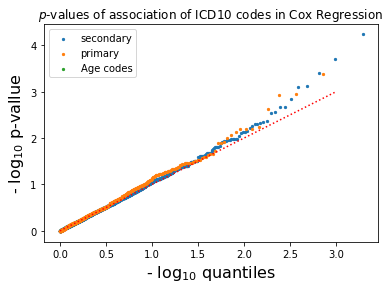

In [61]:
ps = cox_info.loc[(cox_info.n_cases >= 100) & cox_info.index.isin([c for c in all_ICD10_only_secondary if len(c) == 4])].sort_values("p_val")["p_val"]
qs = np.arange(1,ps.shape[0]+1) / ps.shape[0]
plt.scatter(-np.log10(qs),-np.log10(ps),label="secondary",s=5)

ps = cox_info.loc[(cox_info.n_cases >= 100) & cox_info.index.isin(all_ICD10_primary)].sort_values("p_val")["p_val"]
qs = np.arange(1,ps.shape[0]+1) / ps.shape[0]
plt.scatter(-np.log10(qs),-np.log10(ps),label="primary",s=5)

ps = cox_info.loc[(cox_info.n_cases >= 100) & cox_info.index.isin([str(c) for c in ages_codes])].sort_values("p_val")["p_val"]
qs = np.arange(1,ps.shape[0]+1) / ps.shape[0]
plt.scatter(-np.log10(qs),-np.log10(ps),label="Age codes",s=5)

plt.plot([0,3],[0,3],ls=":",c="red")
plt.ylabel("- $\log_{10}$ p-vallue",fontsize=16)
plt.xlabel("- $\log_{10}$ quantiles",fontsize=16)
plt.title("$p$-values of association of ICD10 codes in Cox Regression")
plt.legend();

## Benjamin-Hochberg

In [69]:
def benjamin_hochberg(df,Q = 0.05):
    C = df.sort_values("p_val")
    C["BH"] = Q*(np.arange(1,C.shape[0]+1)/C.shape[0])
    threshold = C.loc[C.p_val <= C.BH,"p_val"].max()
    return C.loc[C.p_val <= threshold]

In [70]:
MIN_N_CASES = 150
benjamin_hochberg(cox_info.loc[(cox_info.n_cases >= MIN_N_CASES) & ~cox_info.index.isin(all_ICD10_secondary) & (cox_info.isnull().sum(axis=1) == 0)])

,desc,n_cases,p_val_ADP,HR_ADP,MLOG10P,p_val,BH


In [71]:
benjamin_hochberg(cox_info.loc[(cox_info.n_cases >= MIN_N_CASES) & cox_info.index.isin(all_ICD10_secondary) & (cox_info.isnull().sum(axis=1) == 0)].sort_values("p_val"))

,desc,n_cases,p_val_ADP,HR_ADP,MLOG10P,p_val,BH


In [72]:
benjamin_hochberg(cox_info.loc[(cox_info.n_cases >= MIN_N_CASES) & (cox_info.isnull().sum(axis=1) == 0)])

,desc,n_cases,p_val_ADP,HR_ADP,MLOG10P,p_val,BH
